# iZcyBurningForest
## Config Initialization

In [155]:
%pip install matplotlib
# also do: sudo apt-get install ffmpeg

Note: you may need to restart the kernel to use updated packages.


## Initialize Packages

In [156]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML  # for embedded matplotlib animation
from math import *
from random import *
import time

matplotlib.rc('animation', html='html5')
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

## Cleaning .mp4 or .gif

In [157]:
import os

def delete_mp4_files(directory):
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # Check if the file ends with '.mp4'
        if filename.endswith(".mp4") or filename.endswith(".gif"):
            # Construct the full path to the file
            file_path = os.path.join(directory, filename)
            # Delete the file
            os.remove(file_path)
            print(f"Deleted: {file_path}")

# Get the current directory
current_directory = os.getcwd()

# Call the function to delete .mp4 files in the current directory
delete_mp4_files(current_directory)


## Defining States

In [158]:
## Define States
global EMPTY, TREE, BURNING, BURNING_MAX
EMPTY = 0
TREE = 1
BURNING = 2
BURNING_MAX = 3

## Colouring

In [159]:
def makeColorGrid(grid):
    n = grid.shape[0]
    colorGrid = np.zeros((n, n, 3))
    colorGrid[:, :, 0] = 1
    colorGrid[:, :, 1] = 1
    for i in range(0, n):
        for j in range(0, n):
            if (grid[i, j] == TREE):
                colorGrid[i, j, 0] = 0.1
                colorGrid[i, j, 1] = 0.75
                colorGrid[i, j, 2] = 0.02
            if (grid[i, j] >= BURNING and grid[i, j] <= BURNING_MAX):
                colorGrid[i, j, 0] = 0.6
                colorGrid[i, j, 1] = 0.2
                colorGrid[i, j, 2] = 0.1
    return colorGrid

## Drawing

In [160]:
def drawing(grids, fireProbability):
    # Convert decimals like #.# into underscore like #_#
    fireProbability = str(fireProbability).replace(".", "_")
    # Extension
    ext = ".gif"
    
    # Create naming
    name = f'Forest Fire-{fireProbability}-(1){ext}'

    # Check if the file already exists
    if os.path.exists(name):
        # If it exists, make a name with incrementing number
        i = 1
        while True:
            name = f'Forest Fire-{fireProbability}-({i}){ext}'
            if not os.path.exists(name):
                break
            i += 1

    # Display the grid with the size equal to the size of the grid
    n = grids.shape[1]
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(-1, n)
    ax.set_ylim(-1, n)
    ax.set_xticks(range(n+1))
    ax.set_yticks(range(n+1))
    ax.grid(True, linestyle='-', linewidth=0.5)
    ax.set_title(name)
    plt.gca().invert_yaxis()

    im = plt.imshow(makeColorGrid(grids[0,:,:]), animated=True)

    # The animation function: called to produce a frame for each generation.
    def updatefig(i, *args):
        im.set_array(makeColorGrid(grids[i,:,:]))
        return im

    grid_ani = animation.FuncAnimation(
        fig, updatefig, save_count = len(grids), interval=500, blit=False)

    grid_ani.save(name, writer="pillow")

    # Show the last frame of the animation    
    plt.imshow(makeColorGrid(grids[-1,:,:]))
    plt.show()

    return grid_ani

## Initialize the Forest

In [161]:
def initForest(n):
    forest = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            forest[i, j] = TREE
    return forest

## Burn the Forest into Grids

In [162]:
def burningForest(forest_span, t, fireProbability):
    n = forest_span
    init = initForest(n)

    forest = np.zeros((t + 1, n, n))
    forest[0, :, :] = init

    # Burn the center
    forest[0, n // 2, n // 2] = BURNING

    # Count the trees
    before_trees = np.sum(forest[0, :, :] == TREE)
    # print(f"Before trees: {before_trees}")

    for time in range(1, t + 1):
        forest[time, :, :] = forest[time - 1, :, :].copy()
        # Count the trees
        # print(f"Trees at time {time}: {np.sum(forest[time, :, :] == TREE)}")
        
        for i in range(0, n):
            for j in range(0, n):
                if (forest[time - 1, i, j] >= BURNING and forest[time - 1, i, j] < BURNING_MAX):
                    forest[time, i, j] = forest[time - 1, i, j] + 1
                if (forest[time, i, j] == TREE):
                    # Define North, South, West, East
                    north = forest[time - 1, i - 1, j] if i > 0 else EMPTY
                    south = forest[time - 1, i + 1, j] if i < n - 1 else EMPTY
                    west = forest[time - 1, i, j - 1] if j > 0 else EMPTY
                    east = forest[time - 1, i, j + 1] if j < n - 1 else EMPTY

                    # Burn with probability if there is a burning tree
                    if (north == BURNING or south == BURNING or west == BURNING or east == BURNING):
                        if (random() < fireProbability):
                            forest[time, i, j] = BURNING
                if (forest[time - 1, i, j] >= BURNING_MAX):
                    forest[time, i, j] = EMPTY
    
    # Draw
    grid_ani = drawing(grids=forest, fireProbability=fireProbability)

    # Count the remaining trees
    after_trees = np.sum(forest[t, :, :] == TREE)
    # print(f"After trees: {after_trees}")

    # Count the percentage of trees burned
    burned_percentage = (before_trees - after_trees) / before_trees * 100
    # Percentage max 2 decimals
    burned_percentage = round(burned_percentage, 2)
    return burned_percentage, grid_ani

## Repeating Burning

In [163]:
def RepeatBurn(forest_span, t, fireProbability, repeat):
    burned_percentages = []
    for _ in range(repeat):
        burned_percentage, _ = burningForest(forest_span, t, fireProbability)
        burned_percentages.append(burned_percentage)
    return burned_percentages

## Initialize Size and Time

In [164]:
# Initialize the Forest
n = 17
t = 8
x = 10
mode = "Avg" # Avg or ViewOne


## Template

In [165]:
def template(fireProbability, mode="ViewOne"):
    if mode == "ViewOne":
        (ptg, grid_ani) = burningForest(forest_span=n, t=t, fireProbability=fireProbability)
        print(f"Fire Probability: {fireProbability}")
        print(f"Percentage: {ptg}")
        return grid_ani

    elif mode == "Avg":
        arr = RepeatBurn(forest_span=n, t=t, fireProbability=fireProbability, repeat=x)
        print(f"Fire Probability: {fireProbability}")
        average = np.mean(arr)
        print(f"Average: {average}")
        return average

## Calculate Each Probabilty

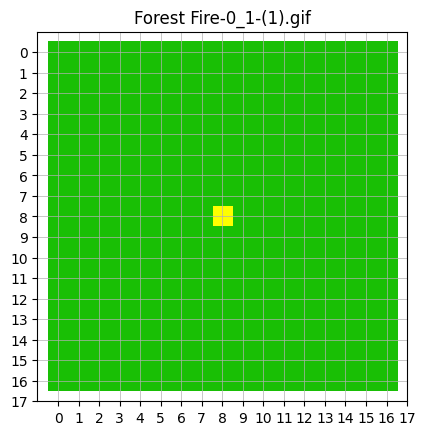

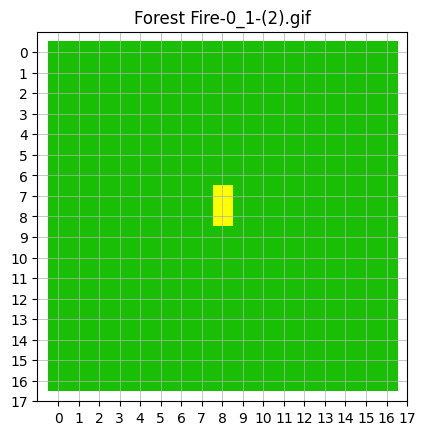

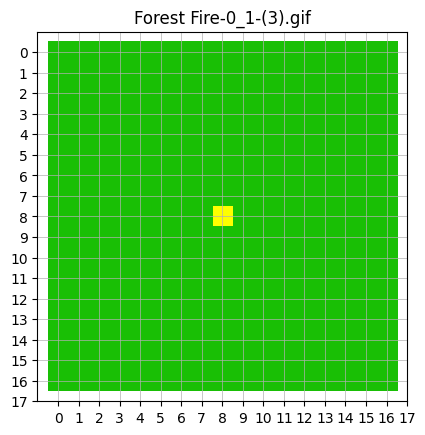

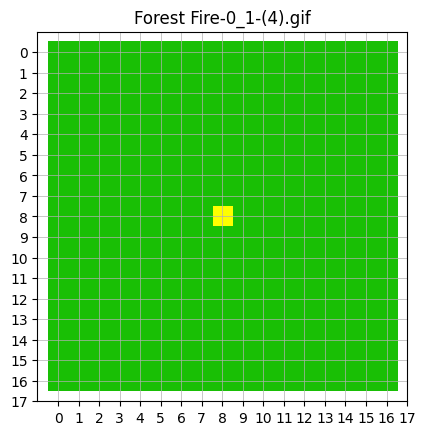

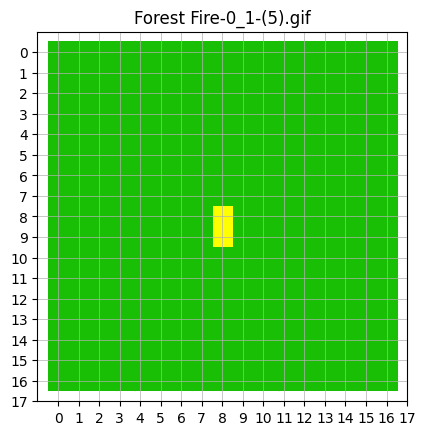

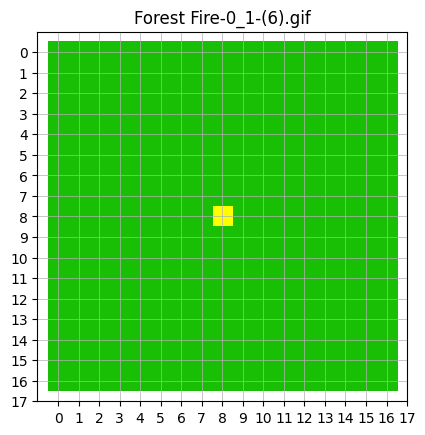

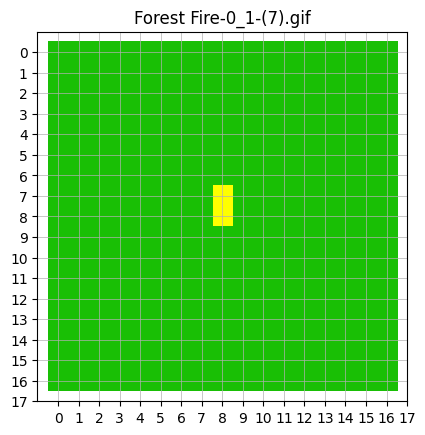

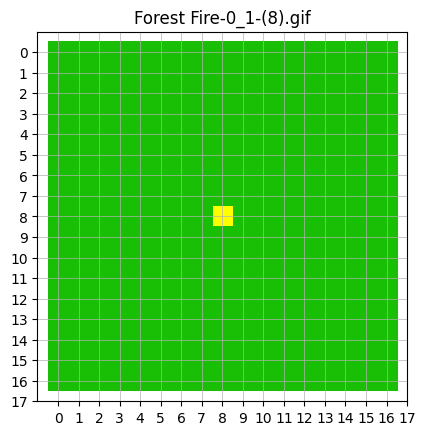

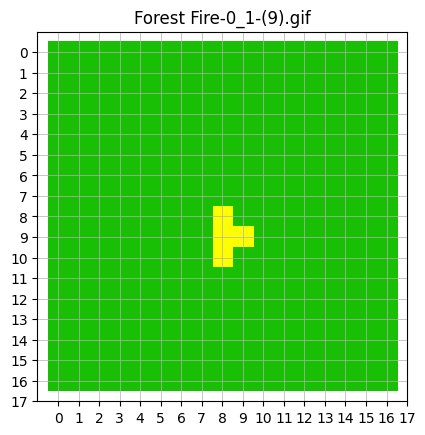

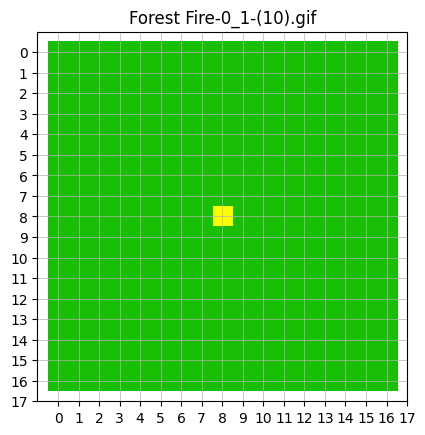

Fire Probability: 0.1
Average: 0.209






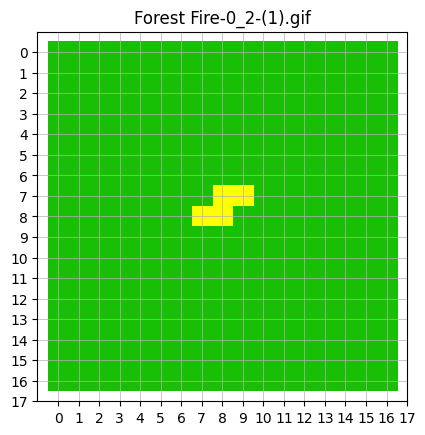

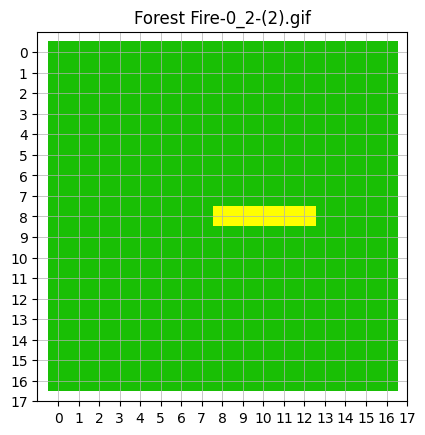

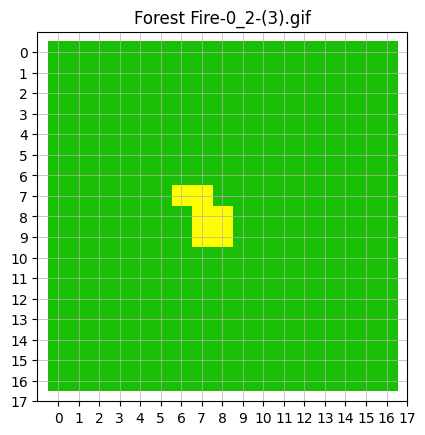

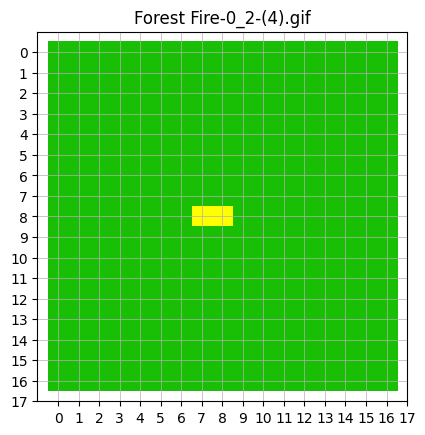

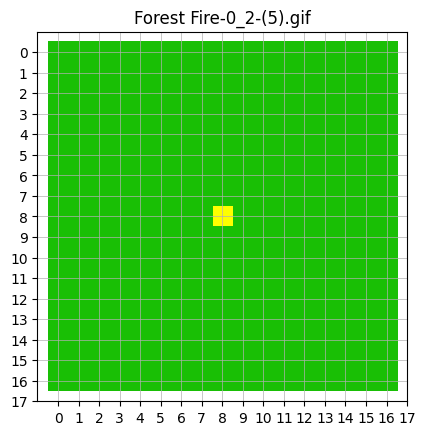

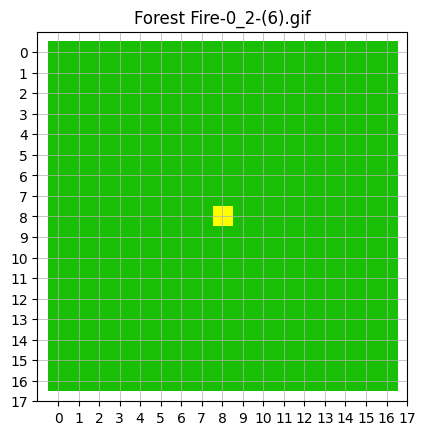

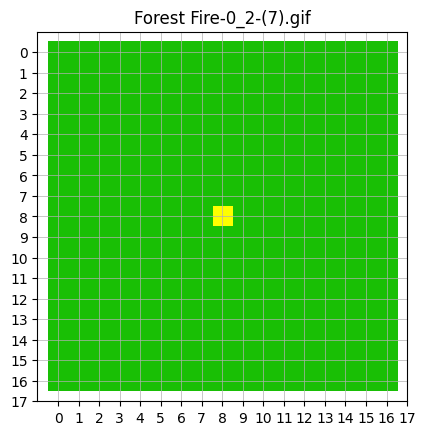

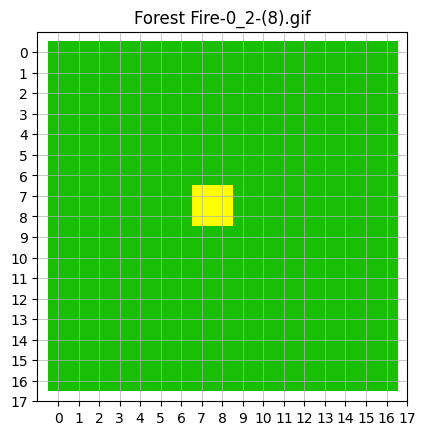

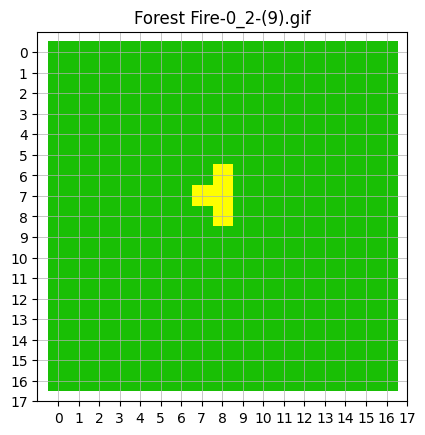

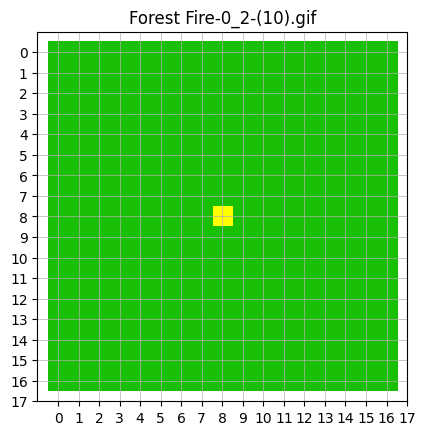

Fire Probability: 0.2
Average: 0.6599999999999999






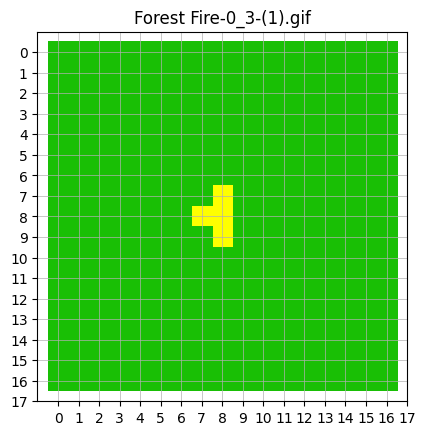

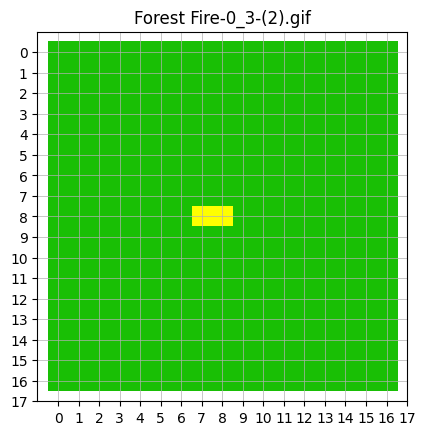

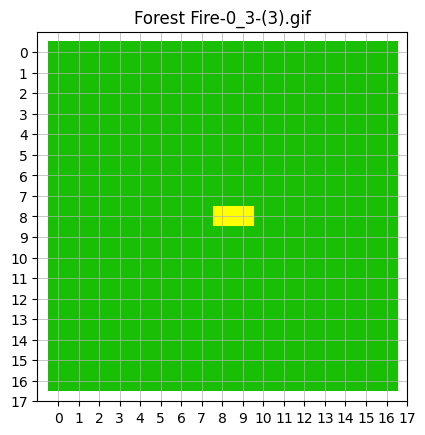

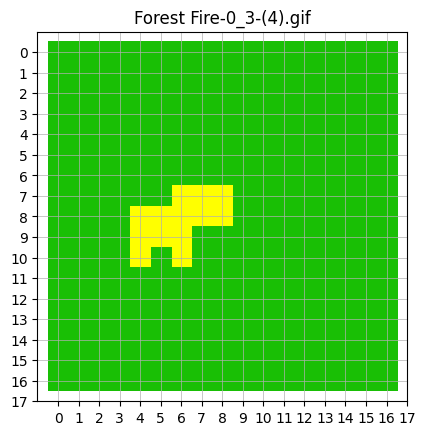

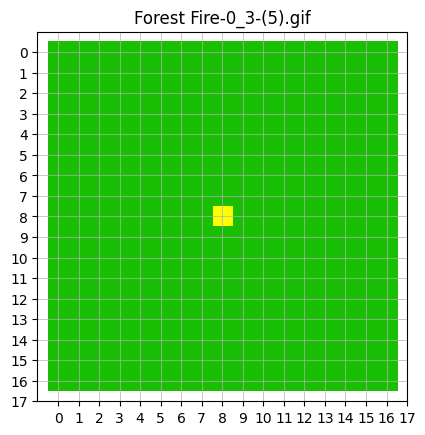

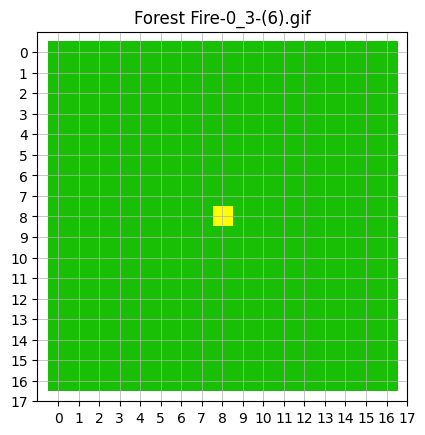

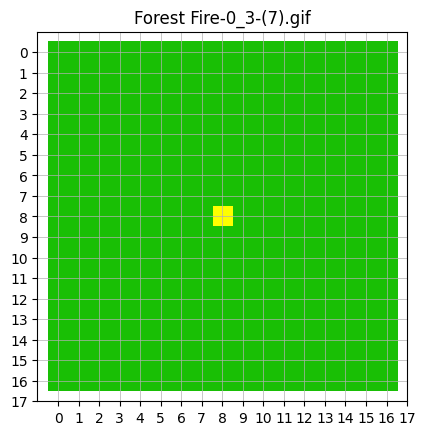

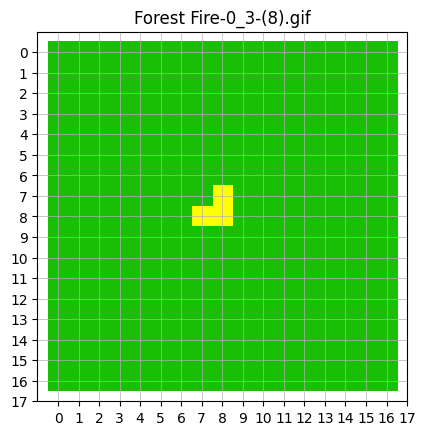

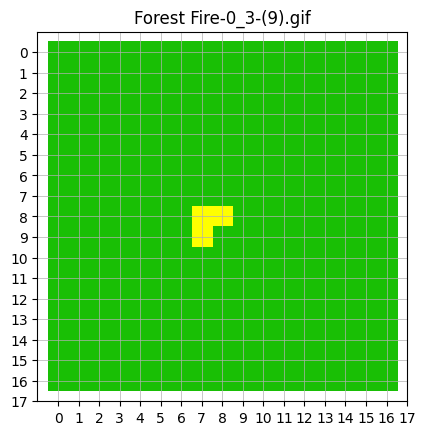

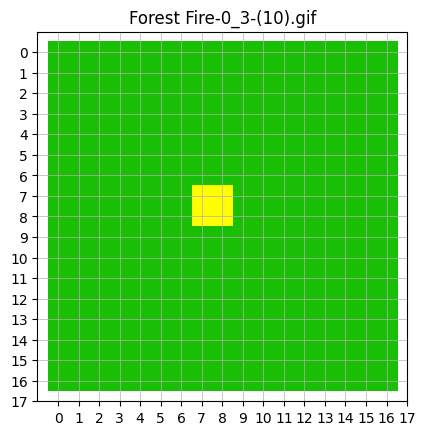

Fire Probability: 0.3
Average: 0.8329999999999999






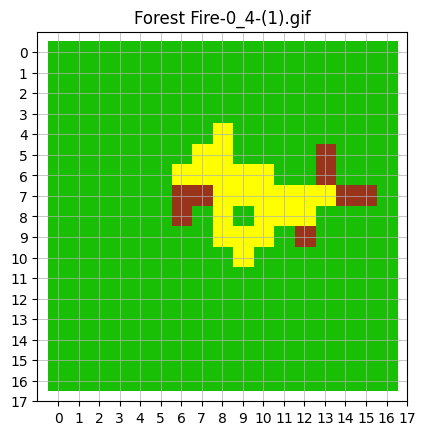

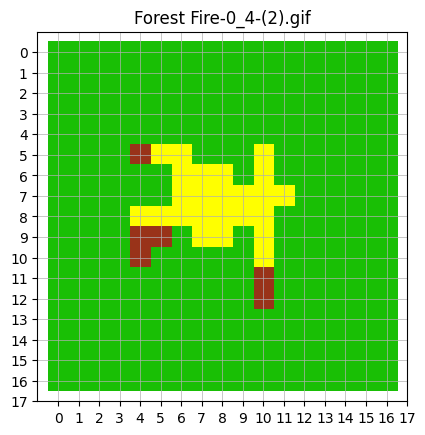

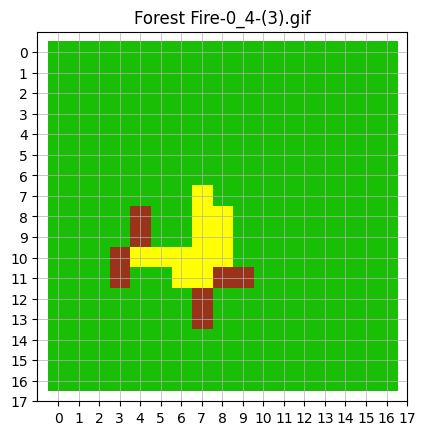

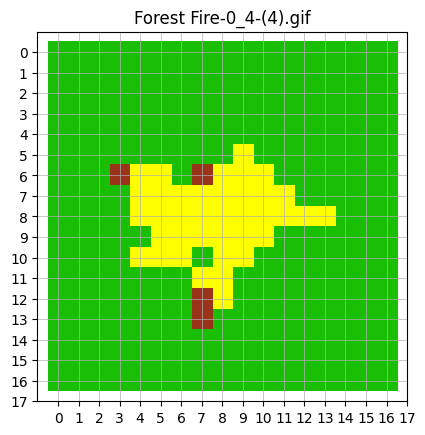

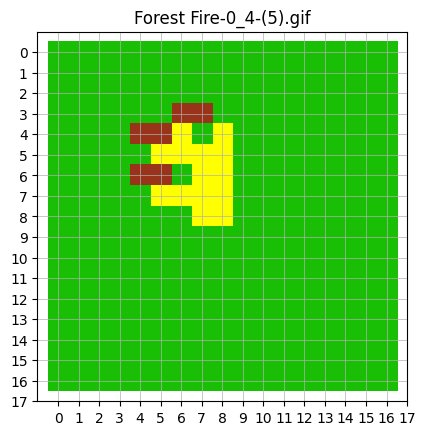

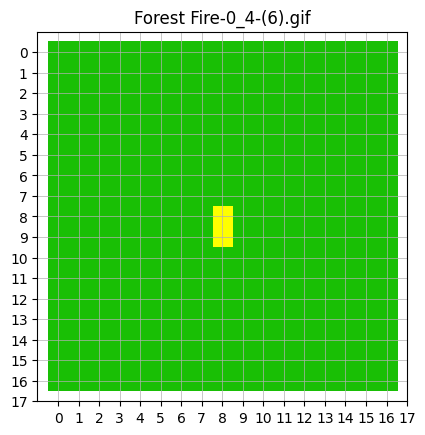

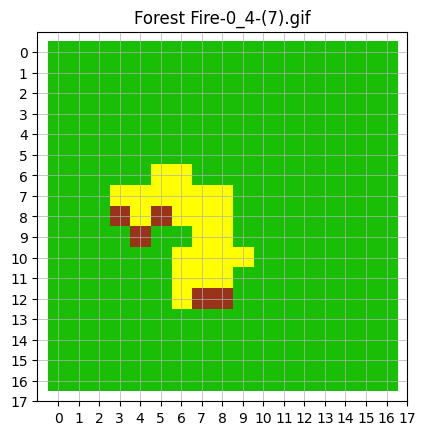

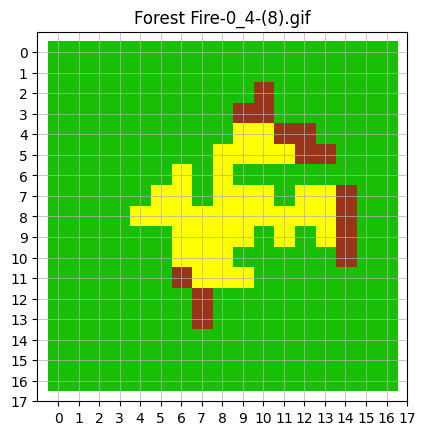

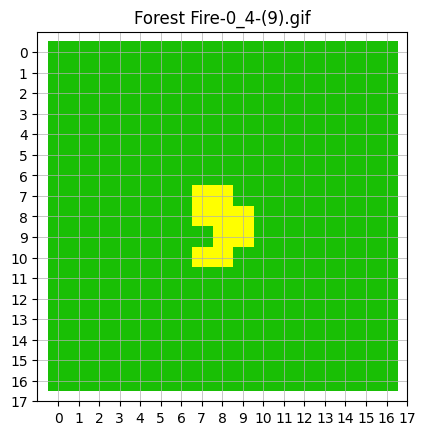

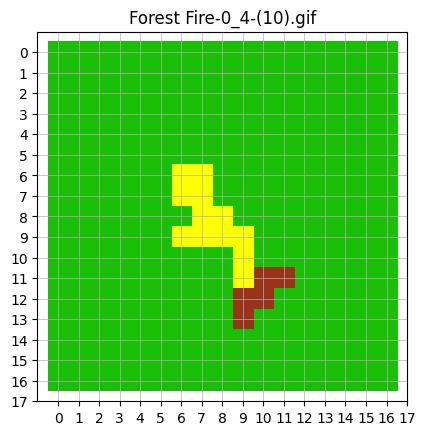

Fire Probability: 0.4
Average: 8.266000000000002






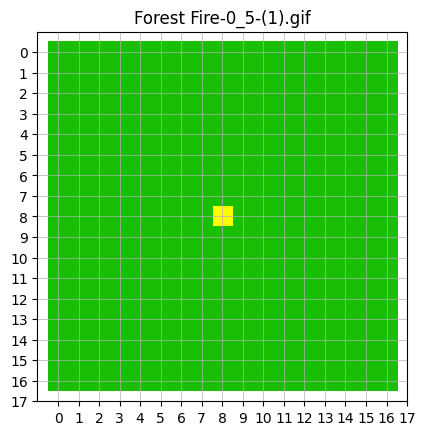

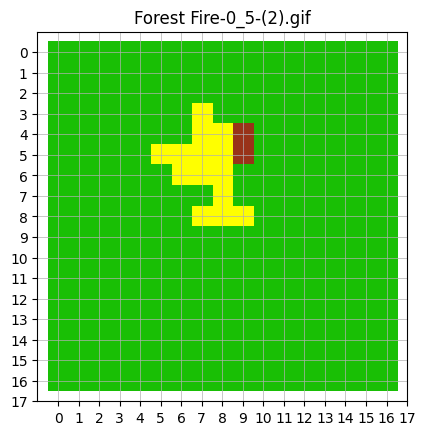

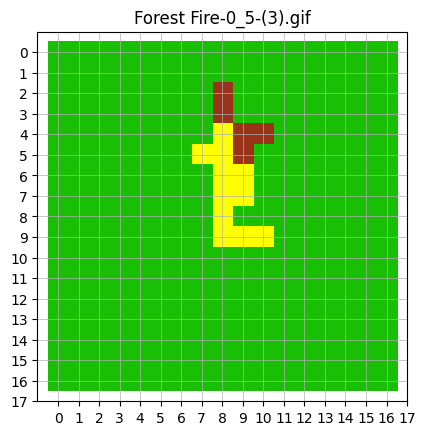

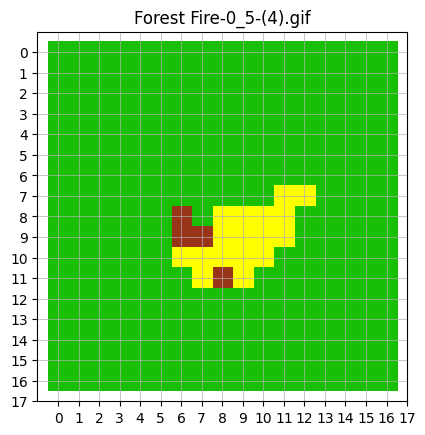

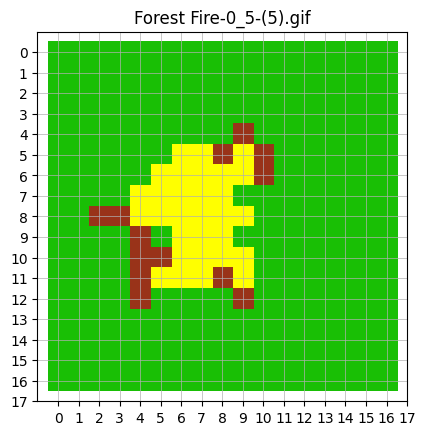

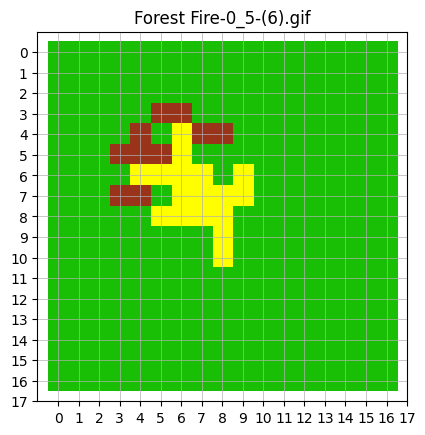

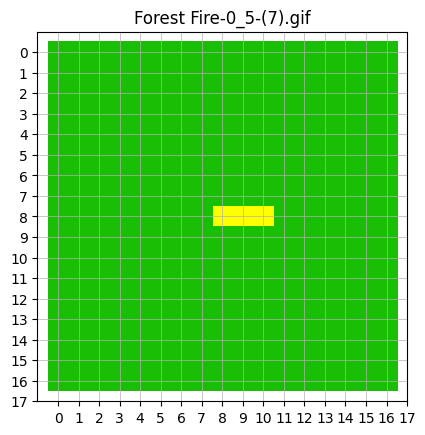

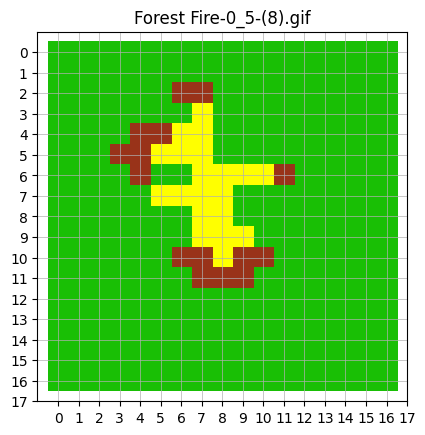

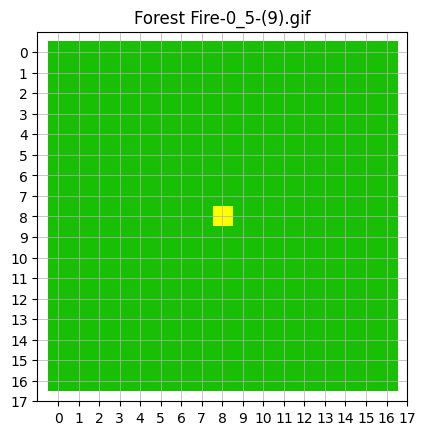

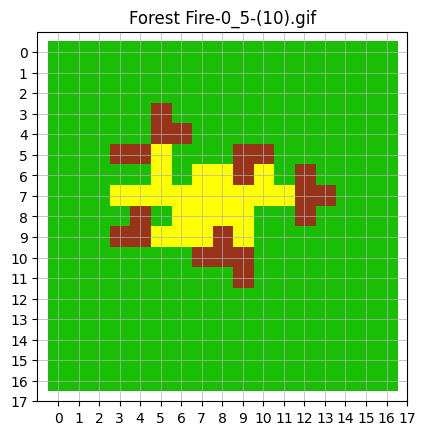

Fire Probability: 0.5
Average: 6.770999999999999






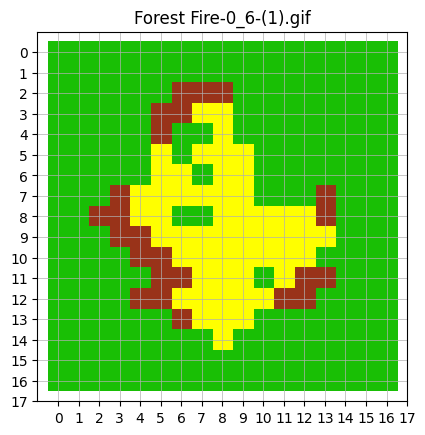

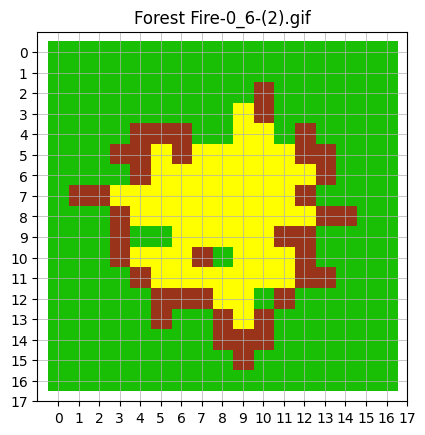

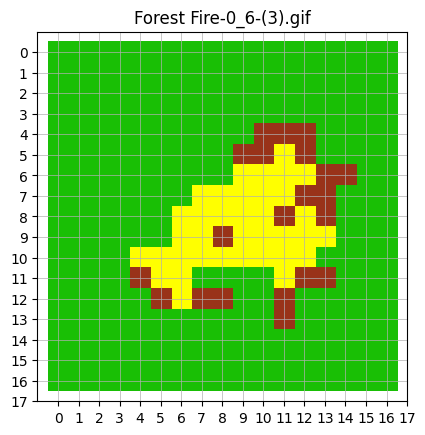

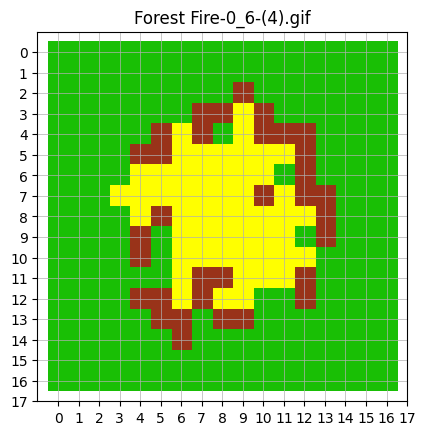

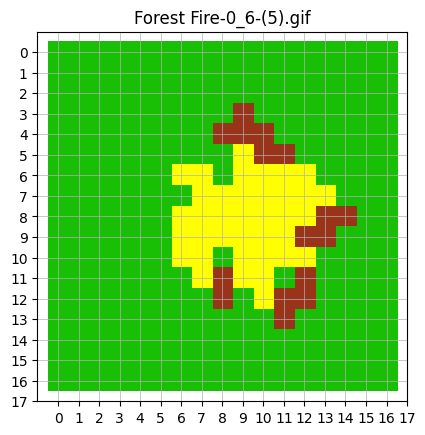

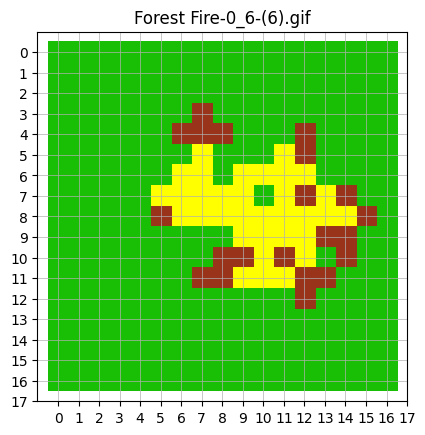

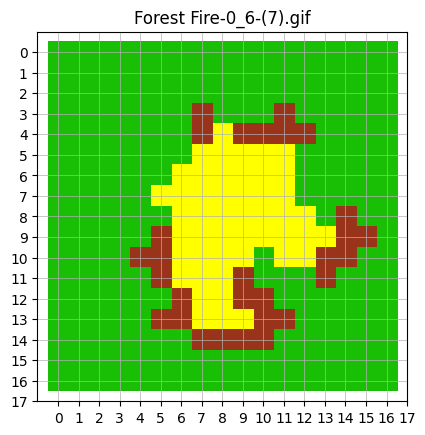

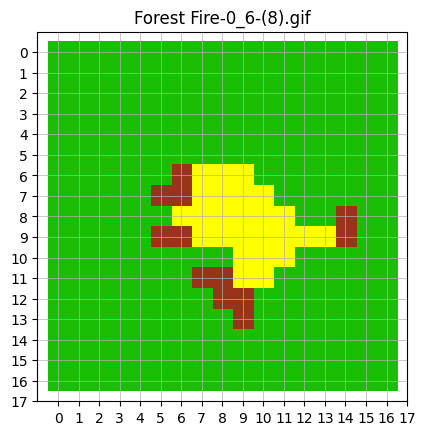

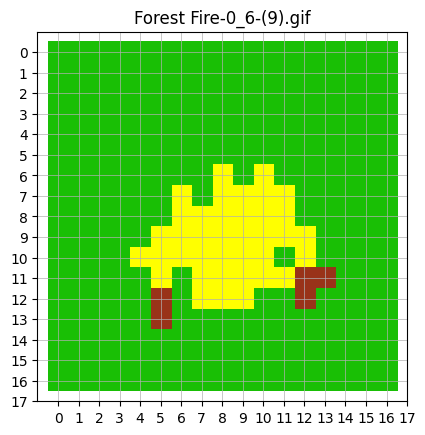

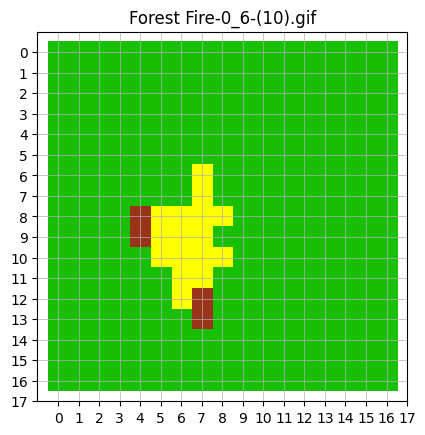

Fire Probability: 0.6
Average: 20.417






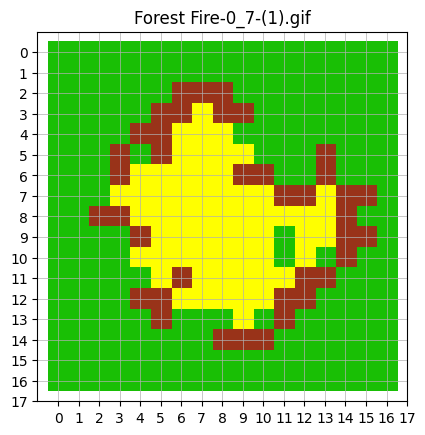

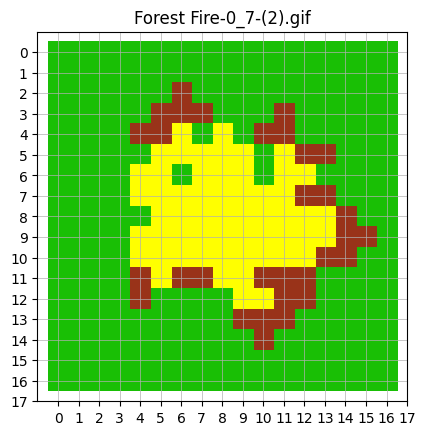

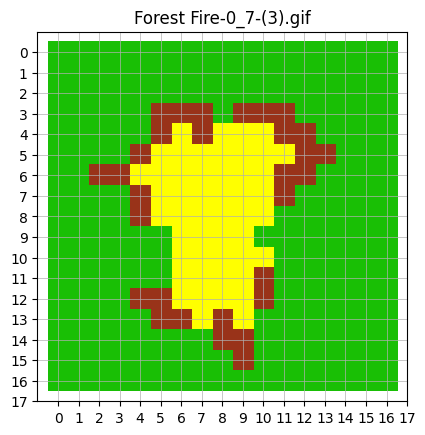

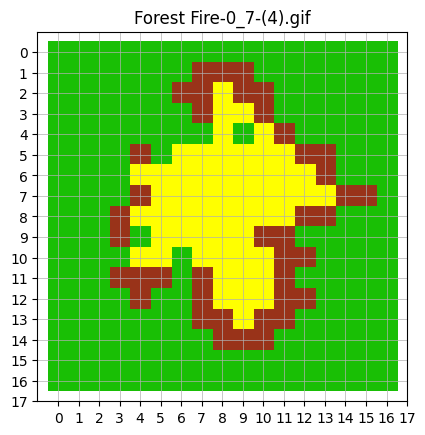

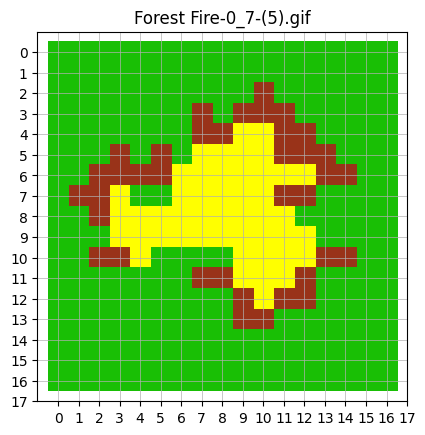

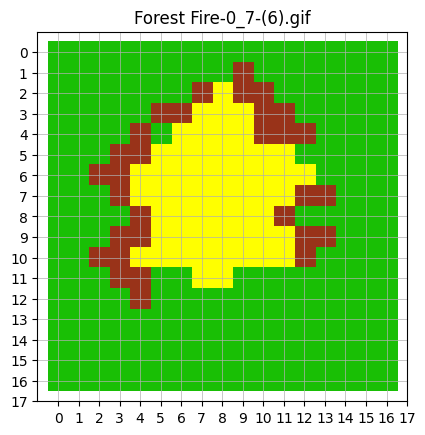

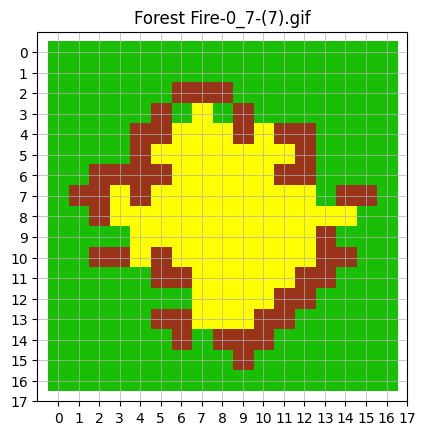

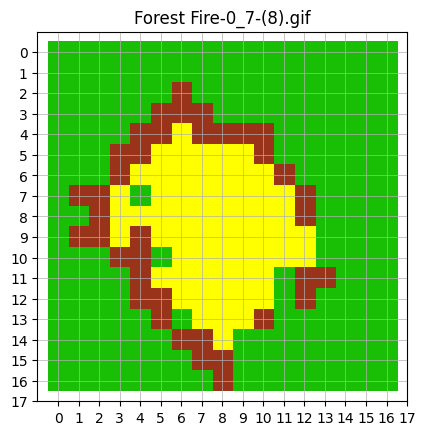

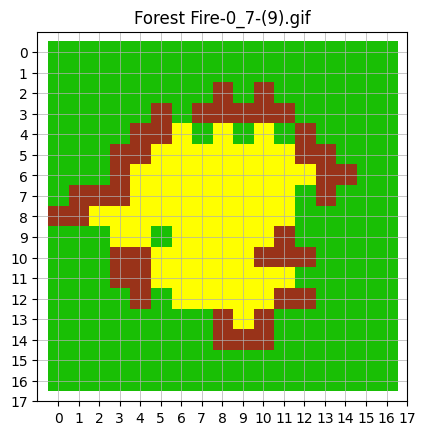

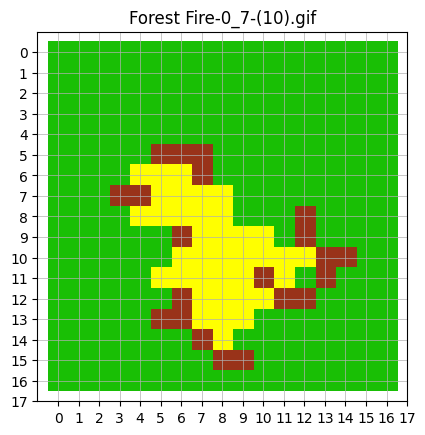

Fire Probability: 0.7
Average: 30.972






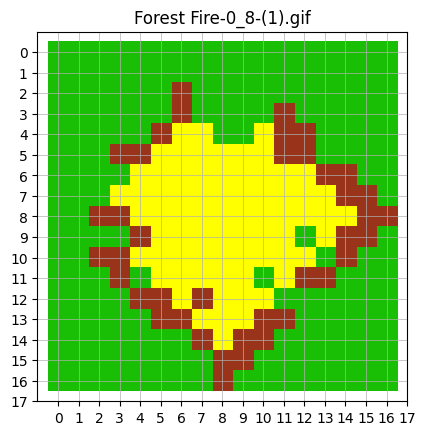

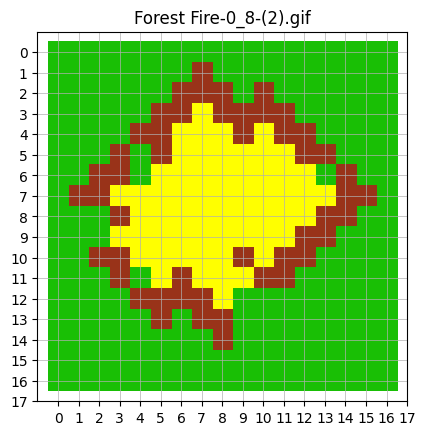

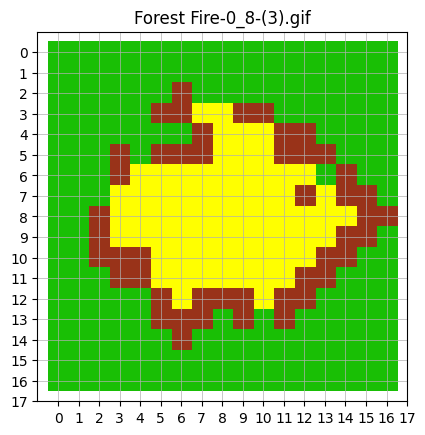

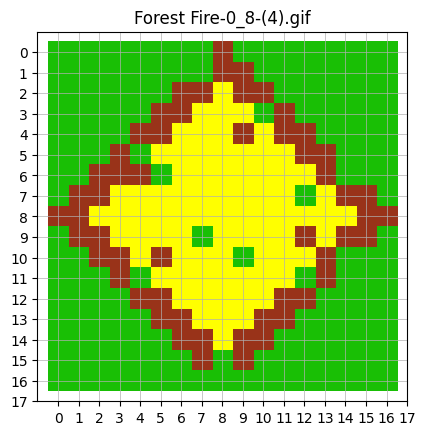

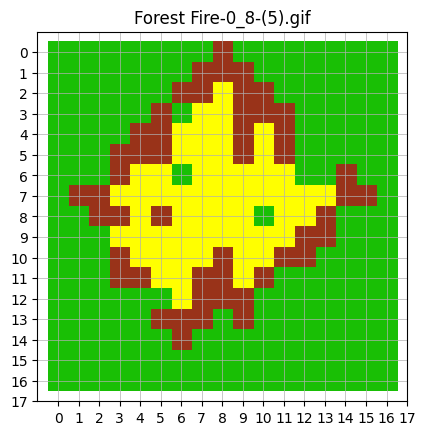

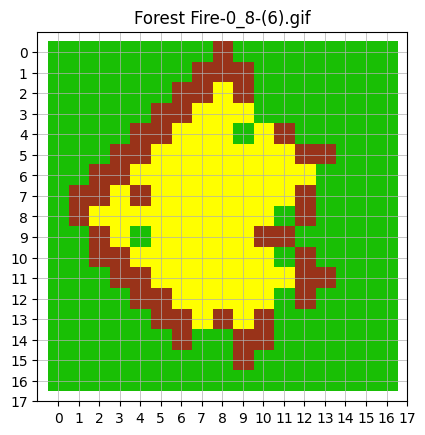

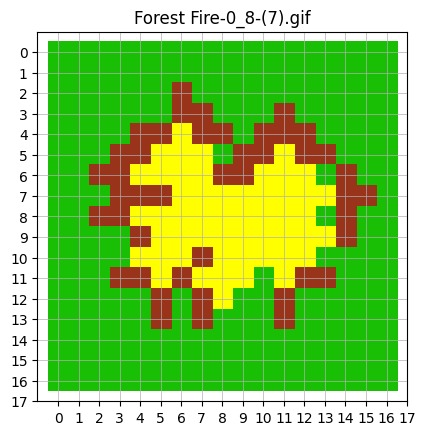

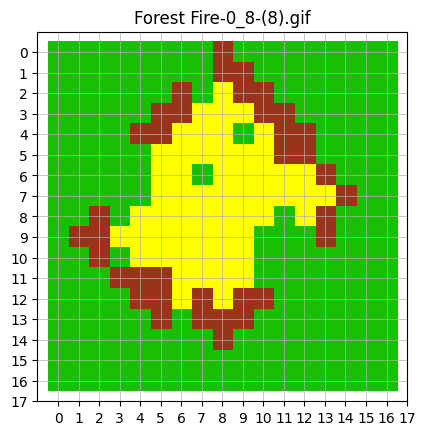

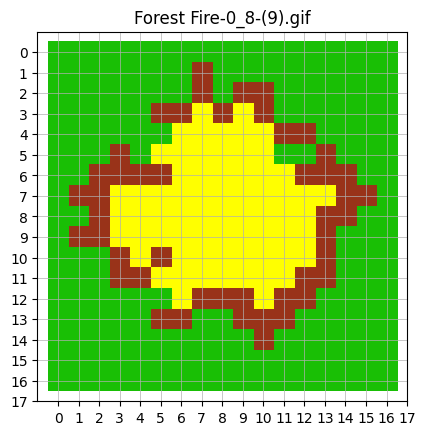

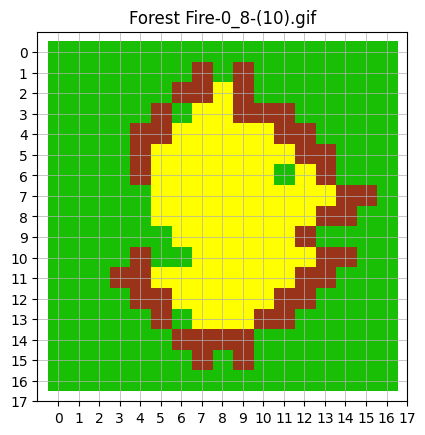

Fire Probability: 0.8
Average: 37.709






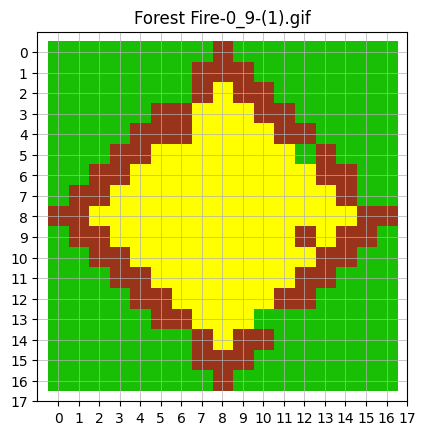

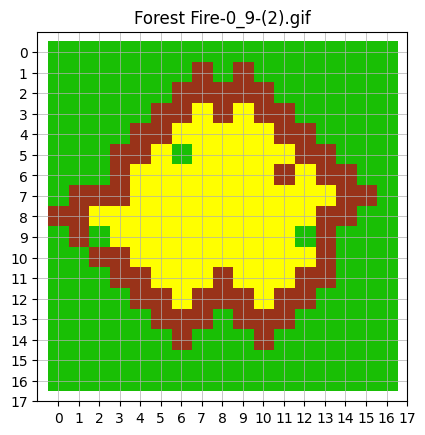

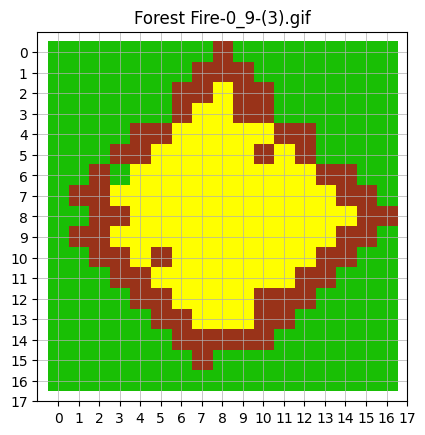

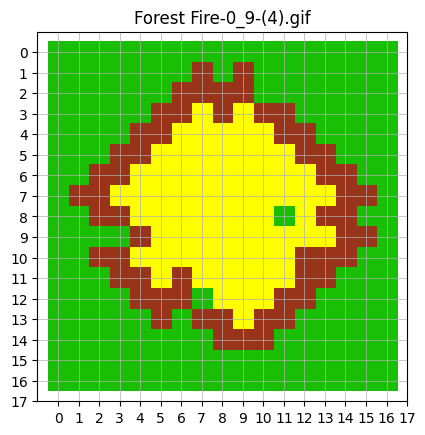

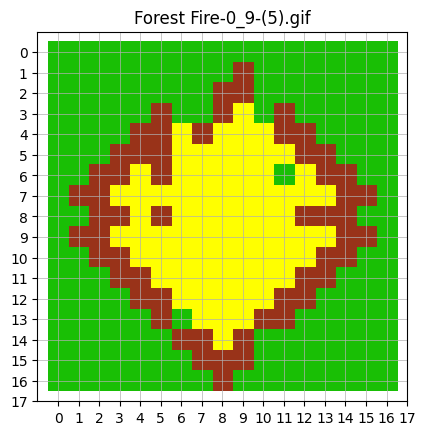

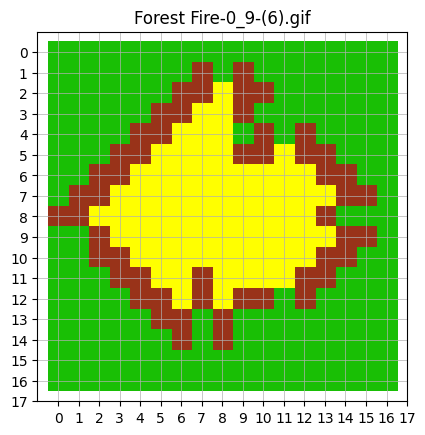

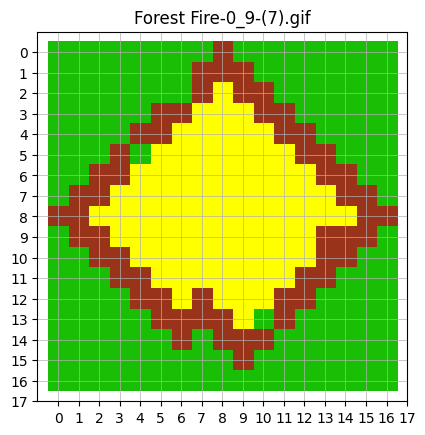

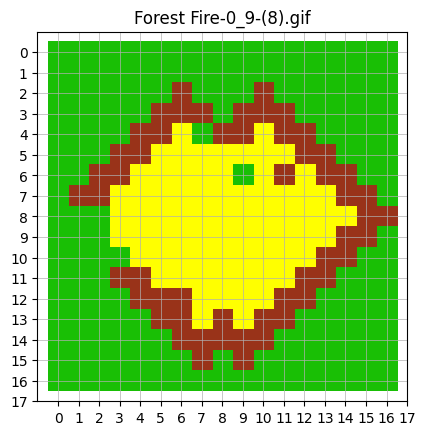

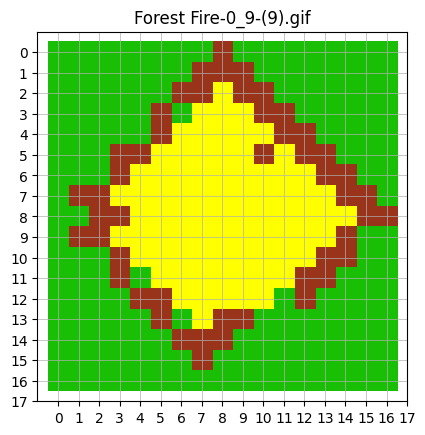

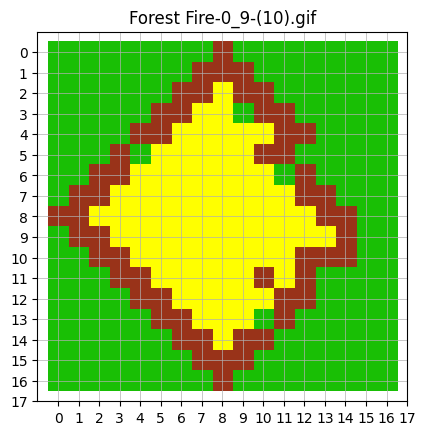

Fire Probability: 0.9
Average: 44.861000000000004




| Fire Probability | Average |
|------------------|---------|
| 0.1              | 0.209   |
| 0.2              | 0.66    |
| 0.3              | 0.833   |
| 0.4              | 8.266   |
| 0.5              | 6.771   |
| 0.6              | 20.417  |
| 0.7              | 30.972  |
| 0.8              | 37.709  |
| 0.9              | 44.861  |


In [166]:
# Run the Simulation
delete_mp4_files(os.getcwd())

avg_list = []
for i in range(1, 10):
    fireProbability = i / 10
    avg = template(fireProbability=fireProbability, mode=mode)
    avg_list.append((fireProbability, avg))
    # HTML(grid_ani.to_html5_video()) if mode == "ViewOne" else None
    # Give space
    print("\n\n\n")

# Print the header
print("| Fire Probability | Average |")
print("|------------------|---------|")

# Iterate over the data and print each row
for fire_prob, average in avg_list:
    # average max 3 decimals
    average = round(average, 3)
    # convert fire_prob to string
    fire_prob = str(fire_prob)
    # convert average to string
    average = str(average)
    # adjust fire_prob to have the lenght of 16
    fire_prob = fire_prob.ljust(16)
    # adjust average to have the lenght of 7
    average = average.ljust(7)
    print(f"| {fire_prob} | {average} |")

## EOF